## Assignment 1 Part 2
### Name: Barun Parua
### Roll Number: 21CS10014

First of all, we import the necessary libraries.

Then we read the data from the csv file and store it in a pandas dataframe. After that randomization is done and the data is split into training, validation and test sets.

After that we print some of the sample data and the shapes of each set. Also the attribute list is generated for later use.

In [190]:
# importing all the necessary libraries
# pandas for reading the csv file, math for mathematical operations, matplotlib for plotting the data
# graphviz for visualizing the decision tree, Image for displaying the image in the notebook
# accuracy_score, precision_score, recall_score, confusion_matrix for calculating the accuracy, precision, recall and confusion matrix
# DecisionTreeClassifier for comparing the accuracy of my model with the inbuilt model of sklearn
import pandas as pd
import matplotlib.pyplot as plt
import math
import graphviz
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

In [191]:
# extracting the data from the csv file, checking the shape of the data
df = pd.read_csv('../../dataset/decision-tree.csv')
print(df.shape)

# randomizing the dataset
df = df.sample(frac=1).reset_index(drop=True)

# printing the first 5 rows of the dataset
print("First 5 rows of the dataset:")
df.head()

(768, 9)
First 5 rows of the dataset:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,12,100,84,33,105,30.0,0.488,46,0
1,11,138,74,26,144,36.1,0.557,50,1
2,0,91,80,0,0,32.4,0.601,27,0
3,2,105,58,40,94,34.9,0.225,25,0
4,10,139,80,0,0,27.1,1.441,57,0


In [192]:
# splitting the dataset into training and testing data
# train set: 60%, validation set: 20%, test set: 20%
train = df.iloc[:int(0.6*len(df)), :]
validation = df.iloc[int(0.6*len(df)):int(0.8*len(df)), :]
test = df.iloc[int(0.8*len(df)):, :]

# check the shape of the data
print("Shape of the training data:", train.shape)
print("Shape of the testing data:", test.shape)
print("Shape of the validation data:", validation.shape)

# get the list of all the attributes
# will be used later when we do the id3 algorithm so that attributes can be passed as a parameter
attributes = df.columns.tolist()[:-1]
print("Attributes:", attributes)

Shape of the training data: (460, 9)
Shape of the testing data: (154, 9)
Shape of the validation data: (154, 9)
Attributes: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


Now, we create the Node for the decision tree. The node has the following attributes:
1. attribute: The attribute on which the node is split
2. value: The value of the attribute on which the node is split
3. outcome: The outcome of the node if it is a leaf node
4. num_samples: The number of data points in the node
5. children: The list(actually dict for easier mapping) of children of the node

Following this, some additional functions are defined:
1. The entropy function is defined which calculates the entropy of a given set of data points.
2. The information gain function is defined which calculates the information gain of a given set of data points on a given attribute.
3. The get_best_split function is defined which calculates the best split for a given set of data points.
4. The id3 function is defined which creates the decision tree using the ID3 algorithm recursively.
The id3 function has a parameter `max_depth` which can be used to limit the depth of the tree.
5. The print_tree function is defined which prints the decision tree in a readable format.

Finally, the decision tree is created using the id3 function and the tree is printed.

In [193]:
# class for the decision tree
class Node:
    def __init__(self, attribute=None, value=None, outcome=None, num_samples=None):
        self.attribute = attribute 
        self.value = value
        self.outcome = outcome
        self.num_samples = num_samples
        self.children = {}

# function to calculate the entropy of the data
def get_entropy(data):
    if len(data) == 0:
        return 0
    p = sum(data['Outcome']) / len(data)
    n = 1 - p
    if p == 0 or n == 0:
        return 0
    return -p * math.log(p, 2) - n * math.log(n, 2)

# function to calculate the information gain based on the attribute and the threshold
def get_information_gain(data, attribute, threshold):
    l = data[data[attribute] <= threshold]
    r = data[data[attribute] > threshold]
    
    if len(l) == 0 or len(r) == 0:
        return -1
    
    total_entropy = get_entropy(data)
    l_entropy = get_entropy(l)
    r_entropy = get_entropy(r)
    return total_entropy - (len(l) / len(data)) * l_entropy - (len(r) / len(data)) * r_entropy

# function to get the best split based on the information gain
def get_best_split(data, attributes):
    best_attribute = None
    best_threshold = None
    best_gain = -1
    
    for attribute in attributes:
        if attribute == 'Outcome':
            continue
        values = data[attribute].unique()
        for value in values:
            gain = get_information_gain(data, attribute, value)
            if gain == -1:
                continue
            if gain >= best_gain:
                best_attribute = attribute
                best_threshold = value
                best_gain = gain
                
    return best_attribute, best_threshold

# function to recursively build the decision tree using all the above functions
# max_depth is the maximum depth of the decision tree for prepruning
# returns the root node of the decision tree
def id3(data, attributes, depth=0, MAX_DEPTH=10):
    outcomes = data['Outcome'].unique()
    if len(outcomes) == 1:
        return Node(outcome=outcomes[0], num_samples=len(data))
    if len(attributes) == 1 or depth >= MAX_DEPTH or len(data) <= 10:
        return Node(outcome=data['Outcome'].mode()[0], num_samples=len(data))
    
    best_attribute, best_threshold = get_best_split(data, attributes)
    if best_attribute is None:
        return Node(outcome=data['Outcome'].mode()[0], num_samples=len(data))
    
    node = Node(attribute=best_attribute, value=best_threshold)
    attributes.remove(best_attribute)
    
    l = data[data[best_attribute] <= best_threshold]
    r = data[data[best_attribute] > best_threshold]
    
    node.children['<='] = id3(l, attributes.copy(), depth + 1, MAX_DEPTH)
    node.children['>'] = id3(r, attributes.copy(), depth + 1, MAX_DEPTH)
    
    return node

# function to print the decision tree in a slightly better format
# will use graphviz to visualize the decision tree later
def print_tree(node, depth=0):
    if node.outcome is not None:
        print("  " * depth + "Outcome:", node.outcome)
    else:
        print("  " * depth + f"Attribute {node.attribute} <= {node.value}:")
        print_tree(node.children['<='], depth + 1)
        print("  " * depth + f"Attribute {node.attribute} > {node.value}:")
        print_tree(node.children['>'], depth + 1)

In [194]:
# generating the decision tree using the training data, passing the attributes as a copy
# subsequently printing the decision tree
tree = id3(train, attributes.copy())
# print_tree(tree)

Now we define the predict function which predicts the outcome of a given data point using the decision tree. Using this function, we predict the outcomes of the validation set and calculate the accuracy.

Then we get the accuracy of the test set and compare it with the sklearn decision tree classifier.

Next we plot the accuracy vs max_depth graph for the validation set and the test set to get the best value of max_depth. (Note that this is commented out as it is required for the part 3, ie the pruned tree not the original tree).

In [195]:
def predict(node, row):
    if node.outcome is not None:
        return node.outcome
    if row[node.attribute] <= node.value:
        return predict(node.children['<='], row)
    else:
        return predict(node.children['>'], row)
    
def get_predictions(node, data):
    predictions = []
    for idx, row in data.iterrows():
        predictions.append(predict(node, row))
    return predictions

predictions = get_predictions(tree, test)
actual = test['Outcome'].tolist()
print("Accuracy without sklearn:", accuracy_score(predictions, actual))

clf = DecisionTreeClassifier(criterion='entropy', max_depth=10)

clf.fit(train[attributes], train['Outcome'])

predictions = clf.predict(test[attributes])
print("Accuracy with sklearn:", accuracy_score(predictions, test['Outcome']))

Accuracy without sklearn: 0.7272727272727273
Accuracy with sklearn: 0.7142857142857143


In [196]:
# # now get a list of accuracies for different values of MAX_DEPTH and plot them to see how the accuracy changes with the depth of the tree
# # store the value of MAX_DEPTH for which the accuracy is maximum
# ## takes a while to run approx 30 seconds!


# accuracies_test = []
# accuracies_validation = []
# max_depth = 0
# max_accuracy = 0
# for i in range(1, 11):
#     tree = id3(train, attributes.copy(), MAX_DEPTH=i)
#     predictions = get_predictions(tree, test)
#     actual = test['Outcome'].tolist()
#     accuracy = accuracy_score(predictions, actual)
#     accuracies_test.append(accuracy)
#     if accuracy > max_accuracy:
#         max_accuracy = accuracy
#         max_depth = i
        
#     predictions = get_predictions(tree, validation)
#     actual = validation['Outcome'].tolist()
#     accuracy = accuracy_score(predictions, actual)
#     accuracies_validation.append(accuracy)
    
# print("Maximum accuracy:", max_accuracy, "for MAX_DEPTH =", max_depth)

# plt.plot(range(1, 11), accuracies_test, label='Test')
# plt.plot(range(1, 11), accuracies_validation, label='Validation')
# plt.xlabel('Max Depth')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

Now we define some functions for the printing of the tree in a good readable format.

A html_label format is used to get the tree output using some html labels so that it is rendered well in the notebook.
The get_dot function is used to get the dot format of the tree which can be used to get the image of the tree using graphviz.

Finally, the tree is printed in a good readable format.

Then we render the tree in the notebook using the image and graphviz modules.

This gives a well readable tree.

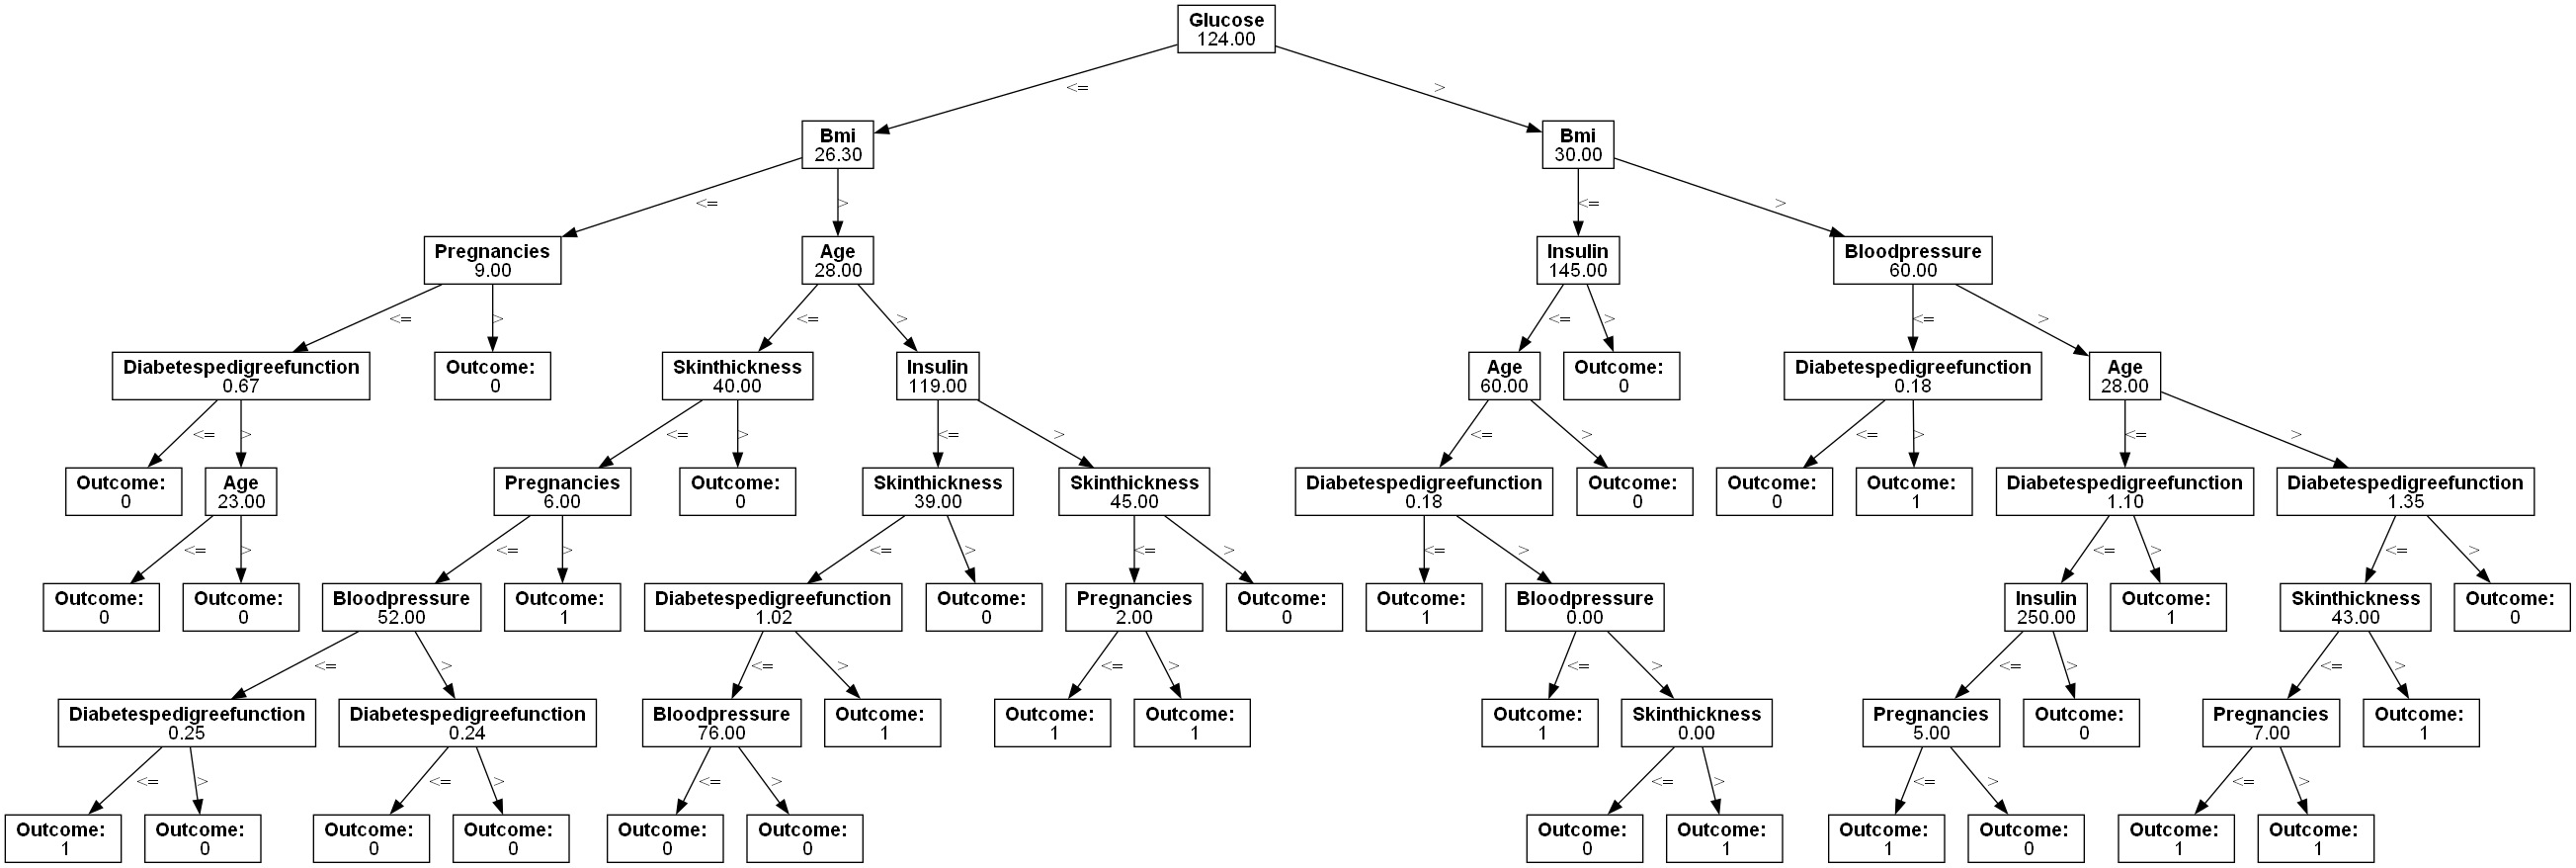

In [197]:
# get the tree in html encoding format
def get_html_label(node):
    if node.outcome is not None:
        return f'<b>Outcome:</b> <br/> {node.outcome}'
    else:
        attribute_name = node.attribute.replace('_', ' ').title()  # Replace underscores and title case
        label = f'<b>{attribute_name}</b><br/>{node.value:.2f}'
        return label

# function to get the DOT representation of the decision tree
def get_dot(node, parent_id='', edge_label='', dot='', node_count=0):
    if node is None:
        return dot, node_count

    node_id = node_count
    node_count += 1

    label = get_html_label(node)
    dot += f'N{node_id} [label=<{label}>, shape=box];\n'

    if parent_id != '':
        dot += f'N{parent_id} -> N{node_id} [label="{edge_label}"];\n'

    if node.children:
        for branch, child_node in node.children.items():
            dot, node_count = get_dot(child_node, node_id, branch, dot, node_count)

    return dot, node_count

# Generate the DOT representation of the decision tree
tree = id3(train, attributes.copy(), MAX_DEPTH=10)
dot, _ = get_dot(tree, dot='', node_count=0)
# print(dot)

# Save the DOT representation to a file
with open('tree.dot', 'w') as f:
    f.write('digraph Tree {\n')
    f.write('node [fontname="Arial"];\n')
    f.write(dot)
    f.write('}\n')
    
# Convert the DOT file to a PNG image and display it
graphviz.render('dot', 'png', 'tree.dot')
Image(filename='tree.dot.png')


Now, we do the pruning of the tree using the reduced error pruning algorithm so that the tree is not overfitted.

A bottom up approach is used for the pruning so that all the nodes are visited only once.

The pruned tree accuracy is calculated and compared with the unpruned tree accuracy.
It is seen that pruning improves the accuracy of the tree by a significant amount in most cases.

In [198]:
# reduced error pruning
# start at the leaves and work upwards towards the root
# at each node, remove the subtree if the resulting tree performs no worse than the original on the test set
# repeat until further pruning is harmful

# Get the accuracy of the original tree
tree = id3(train, attributes.copy(), MAX_DEPTH=10)
predictions_original = get_predictions(tree, test)
actual = test['Outcome'].tolist()
accuracy_original = accuracy_score(predictions_original, actual)
print("Original Tree Accuracy:", accuracy_original)

# do the bottom up pruning using the validation set and accuracy score at each node
def bottom_up_pruning(node, data):
    if node.outcome is None:
        if node.children['<='].outcome is None:
            bottom_up_pruning(node.children['<='], data)
        if node.children['>'].outcome is None:
            bottom_up_pruning(node.children['>'], data)

        if node.children['<='].outcome is not None and node.children['>'].outcome is not None:
            # Calculate accuracy of the subtree on the test set
            predictions = get_predictions(node, data)
            actual = data['Outcome'].tolist()
            accuracy = accuracy_score(predictions, actual)

            # Calculate accuracy if the subtree was pruned (both children have outcomes)
            if node.children['<='].num_samples is not None and node.children['>'].num_samples is not None:
                if node.children['<='].num_samples > node.children['>'].num_samples:
                    outcome = node.children['<='].outcome
                else:
                    outcome = node.children['>'].outcome
                predictions = [outcome] * len(data)
                accuracy_pruned = accuracy_score(predictions, actual)

                # If pruned accuracy is better, then prune the subtree
                if accuracy_pruned >= accuracy:
                    node.outcome = outcome
                    node.num_samples = node.children['<='].num_samples + node.children['>'].num_samples
                    node.children = {}

pruned_tree = tree

# Apply bottom-up pruning to the cloned tree
bottom_up_pruning(pruned_tree, validation)

# Get the accuracy of the pruned tree
predictions_pruned = get_predictions(pruned_tree, test)
actual = test['Outcome'].tolist()
accuracy_pruned = accuracy_score(predictions_pruned, actual)
print("Pruned Tree Accuracy:", accuracy_pruned)

Original Tree Accuracy: 0.7272727272727273
Pruned Tree Accuracy: 0.7402597402597403


Now we plot the accuracy vs max_depth graph for the validation set and the test set to get the best value of max_depth for the pruned tree. We can see that it is somewhat better than the unpruned tree.

Maximum accuracy: 0.7857142857142857 for MAX_DEPTH = 2


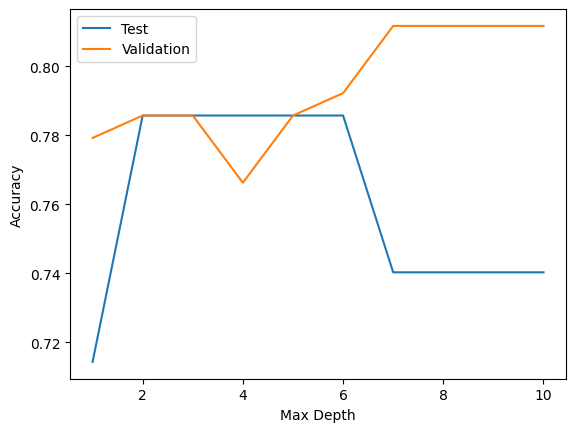

In [199]:
accuracies_test = []
accuracies_validation = []
max_depth = 0
max_accuracy = 0
for i in range(1, 11):
    tree = id3(train, attributes.copy(), MAX_DEPTH=i)
    # prune the tree
    bottom_up_pruning(tree, validation)
    predictions = get_predictions(tree, test)
    actual = test['Outcome'].tolist()
    accuracy = accuracy_score(predictions, actual)
    accuracies_test.append(accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        max_depth = i
        
    predictions = get_predictions(tree, validation)
    actual = validation['Outcome'].tolist()
    accuracy = accuracy_score(predictions, actual)
    accuracies_validation.append(accuracy)
    
print("Maximum accuracy:", max_accuracy, "for MAX_DEPTH =", max_depth)

plt.plot(range(1, 11), accuracies_test, label='Test')
plt.plot(range(1, 11), accuracies_validation, label='Validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Finally, the pruned tree is printed in a good readable format.

Then we render the pruned tree in the notebook using the image and graphviz modules.

Then finally, the macro accuracy, macro precision and macro recall are calculated and printed for the pruned tree.

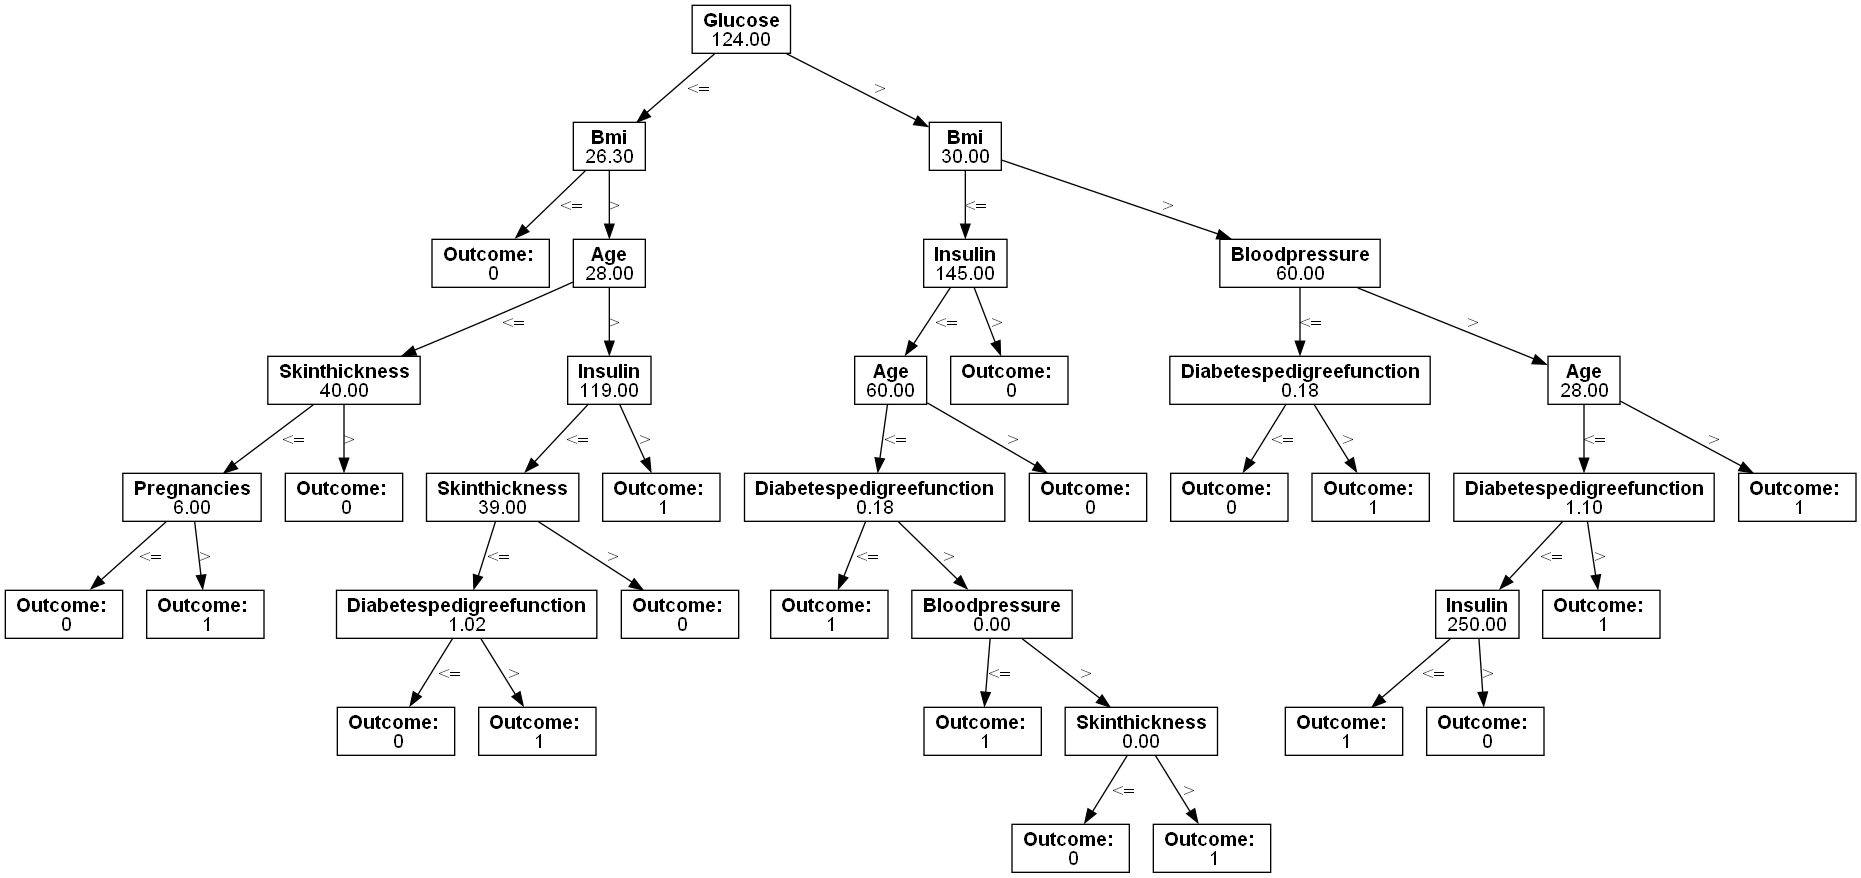

In [200]:
# print the pruned tree
# print_tree(pruned_tree)

tree = id3(train, attributes.copy(), MAX_DEPTH=10)
pruned_tree = tree
bottom_up_pruning(pruned_tree, validation)

# get the dot representation of the pruned tree
dot, _ = get_dot(pruned_tree, dot='', node_count=0)
# print(dot)

# save the dot representation to a file
with open('pruned_tree.dot', 'w') as f:
    f.write('digraph Tree {\n')
    f.write('node [fontname="Arial"];\n')
    f.write(dot)
    f.write('}\n')
    
# convert the dot file to a png image
graphviz.render('dot', 'png', 'pruned_tree.dot')
Image(filename='pruned_tree.dot.png')

In [205]:
# calculating mean macro accuracy, precision, recall
# macro accuracy is the average of the accuracy of each class
# macro precision is the average of the precision of each class
# macro recall is the average of the recall of each class

# get the predictions of the pruned tree
predictions = get_predictions(pruned_tree, test)
actual = test['Outcome'].tolist()

print("Macro Accuracy (sklearn):", accuracy_score(predictions, actual, normalize=True))
print("Macro Precision (sklearn):", precision_score(predictions, actual, average='macro'))
print("Macro Recall (sklearn):", recall_score(predictions, actual, average='macro'))

Macro Accuracy (sklearn): 0.7402597402597403
Macro Precision (sklearn): 0.6990825688073394
Macro Recall (sklearn): 0.689795918367347


End of the notebook. Thank you.